# TF-IDF
- Daniel Branco, 20220599
- Fernando Cruz, 20220646
- Inês Ventura, 20220612
- Maria Mendonça, 20220625

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import layers, initializers, optimizers, metrics, losses
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.utils import plot_model
from keras.layers import concatenate
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Text Mining/

/content/drive/.shortcut-targets-by-id/1N9Y-dcZIQh9qUPRXgB1grO-NTXypIRl8/Text Mining


### Try models with unprocessed data:

In [ ]:
airbnb_df_train = pd.read_excel('train.xlsx')
reviews_df_train = pd.read_excel('train_reviews.xlsx')

In [ ]:
airbnb_df_train.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [ ]:
reviews_df_train.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [ ]:
reviews_grouped_unprocessed = reviews_df_train.groupby('index').agg({
    'comments': str
}).reset_index()


merged_unprocessed = pd.merge(reviews_grouped_unprocessed, airbnb_df_train, on='index', how='right')

# Fill missing values with empty lists
merged_unprocessed.fillna('', inplace=True)

# Set 'apartment_id' as the index
merged_unprocessed.set_index('index', inplace=True)

In [ ]:
merged_unprocessed['combined_text'] = merged_unprocessed['comments'] + merged_unprocessed['host_about'] + merged_unprocessed['description']

In [ ]:
train_unprocessed, test_unprocessed = train_test_split(merged_unprocessed, test_size = 0.3)

In [ ]:
tfidf_train_unprocessed = TfidfVectorizer(max_features=10000)
tfidf_test_unprocessed = TfidfVectorizer(max_features=10000)

train_features_unprocessed = tfidf_train_unprocessed.fit_transform(train_unprocessed['combined_text']).todense()
test_features_unprocessed = tfidf_test_unprocessed.fit_transform(test_unprocessed['combined_text']).todense()

In [ ]:
df_unprocessed = pd.DataFrame(train_features_unprocessed[0].T, index=tfidf_train_unprocessed.get_feature_names_out(), columns=["TF-IDF"])
df_unprocessed = df_unprocessed.sort_values('TF-IDF', ascending=False)
print (df_unprocessed.head(25))

            TF-IDF
se        0.309954
de        0.255452
não       0.203295
tem       0.186754
europa    0.171292
melhores  0.141721
só        0.134783
mais      0.129738
praias    0.127762
há        0.126452
do        0.122507
br        0.121106
também    0.113533
adoro     0.112834
estar     0.105849
tornou    0.105229
perto     0.104300
em        0.103655
dão       0.101387
chega     0.100318
quentes   0.100318
cores     0.099328
disso     0.099328
número    0.098407
lisboa    0.096347


### MLP model:

In [ ]:
input_dim = train_features_unprocessed.shape[1]

mlp_unprocessed = Sequential([
    layers.Input(shape=input_dim),
    BatchNormalization(),
    Dense(64),
    Activation('relu'),
    Dropout(0.3),
    Dense(32),
    Activation('relu'),
    Dropout(0.2),
    Dense(1),
    Activation('sigmoid')
], name='mlp_unprocessed')

mlp_unprocessed.summary()

Model: "mlp_unprocessed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (None, 10000)            40000     
 hNormalization)                                                 
                                                                 
 dense_26 (Dense)            (None, 64)                640064    
                                                                 
 activation_25 (Activation)  (None, 64)                0         
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 activation_26 (Activation)  (None, 32)                0         
                                                   

In [ ]:
mlp_unprocessed.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(),
             metrics=['binary_accuracy'])

In [ ]:
epochs = 5
mlp_unprocessed_history = mlp_unprocessed.fit(train_features_unprocessed, train_unprocessed['unlisted'], epochs=epochs, batch_size=16, validation_split=0.3)

Epoch 1/5
383/383 [==============================] - 8s 15ms/step - loss: 0.4211 - binary_accuracy: 0.8239 - val_loss: 0.4623 - val_binary_accuracy: 0.7573
Epoch 2/5
383/383 [==============================] - 6s 15ms/step - loss: 0.2692 - binary_accuracy: 0.8940 - val_loss: 0.3696 - val_binary_accuracy: 0.8594
Epoch 3/5
383/383 [==============================] - 6s 15ms/step - loss: 0.2012 - binary_accuracy: 0.9198 - val_loss: 0.4134 - val_binary_accuracy: 0.8869
Epoch 4/5
383/383 [==============================] - 5s 14ms/step - loss: 0.1453 - binary_accuracy: 0.9446 - val_loss: 0.4958 - val_binary_accuracy: 0.8690
Epoch 5/5
383/383 [==============================] - 5s 14ms/step - loss: 0.1215 - binary_accuracy: 0.9544 - val_loss: 0.4889 - val_binary_accuracy: 0.8804


### Evaluation:

118/118 [==============================] - 1s 6ms/step - loss: 1.3679 - binary_accuracy: 0.6754
Test Score: 1.3678544759750366
Test Accuracy: 0.6753801107406616


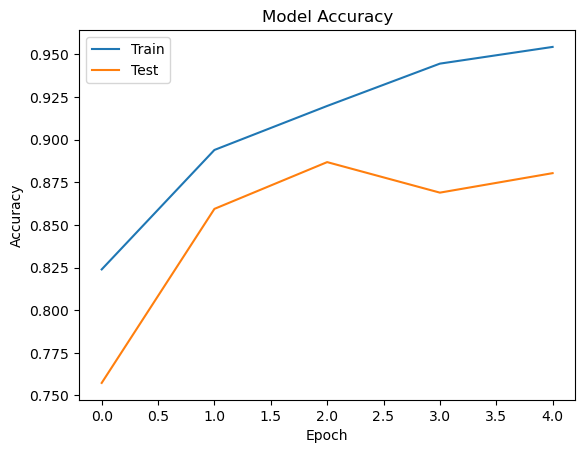

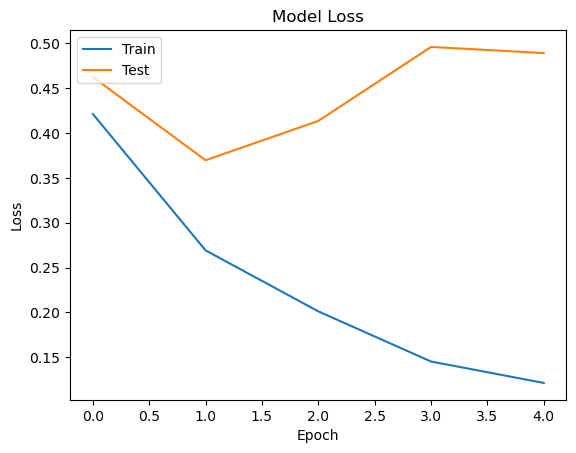

In [ ]:
# Predictions on the Test Set
score = mlp_unprocessed.evaluate(test_features_unprocessed, test_unprocessed['unlisted'], verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
import matplotlib.pyplot as plt

plt.plot(mlp_unprocessed_history.history['binary_accuracy'])
plt.plot(mlp_unprocessed_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(mlp_unprocessed_history.history['loss'])
plt.plot(mlp_unprocessed_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


118/118 [==============================] - 1s 4ms/step


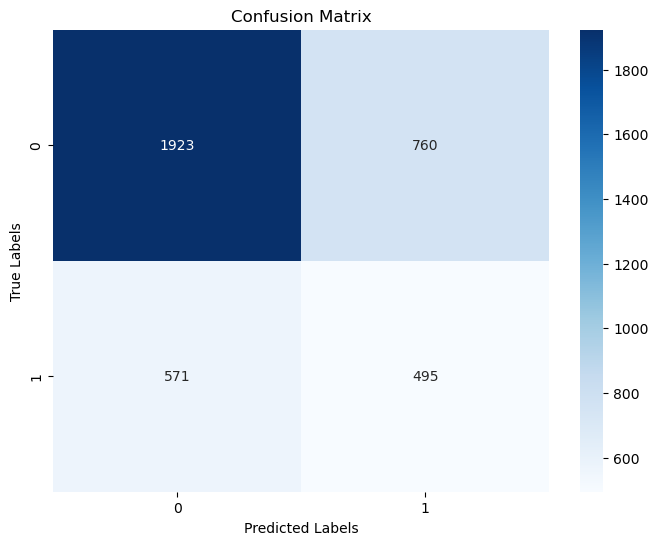

In [ ]:
# Make predictions
predictions = mlp_unprocessed.predict(test_features_unprocessed)

threshold = 0.20
binary_predictions = np.where(predictions >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(test_unprocessed['unlisted'], binary_predictions)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(test_unprocessed['unlisted'], binary_predictions))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      2683
           1       0.39      0.46      0.43      1066

    accuracy                           0.64      3749
   macro avg       0.58      0.59      0.58      3749
weighted avg       0.66      0.64      0.65      3749



## Try models with processed data:

In [ ]:
with open('preprocessed_train_df.pickle', 'rb') as data:
    reviews_preprocessed = pickle.load(data)

In [ ]:
with open('preprocessed_airbnb_df_train.pickle', 'rb') as data:
    airbnb_preprocessed = pickle.load(data)

In [ ]:
reviews_preprocessed.head(10)

,apartment_id,comments,word_count,language,sentiment
0,1,"[cozy, comfortable, house, stay, in.never, wor...",28,en,positive
1,1,"[hostel, experience, pretty, hard, beat, place...",261,en,positive
2,1,"[hostel, neu, funktionieren, tadellos, schnell...",81,de,positive
3,1,"[fine, dorm, think, people, stay, far, bathroo...",27,en,positive
4,1,"[stay, lisbon, tip, hostel, good, mixed, room,...",42,en,positive
5,1,"[close, shop, town, comfortable, place, stay]",12,en,positive
6,1,"[young, friendly, staff, great, location, metr...",74,en,positive
7,5,"[bel, appartemer, magnifique, vue, plage, mer,...",47,fr,positive
8,5,"[appartement, refaire, neuf, confortable, spac...",34,fr,positive
9,5,"[apartamento, limpio, amplio, vista, inmejorab...",35,es,positive


In [ ]:
# Group the 'reviews_preprocessed' DataFrame by 'apartment_id' and aggregate the columns as lists
reviews_grouped = reviews_preprocessed.groupby('apartment_id').agg({
    'comments': list,
    'word_count': list,
    'sentiment': list,
    'language': list
}).reset_index()

reviews_grouped['comments'] = reviews_grouped['comments'].apply(lambda x: [item for sublist in x for item in sublist])

merged_processed = pd.merge(reviews_grouped, airbnb_preprocessed, left_on='apartment_id', right_index=True, how='right')

# Fill missing values with empty lists
merged_processed.fillna('', inplace=True)

# Set 'apartment_id' as the index
merged_processed.set_index('apartment_id', inplace=True)
merged_processed.drop('index', axis=1, inplace=True)

In [ ]:
reviews_grouped.head()

,apartment_id,comments,word_count,sentiment,language
0,1,"[cozy, comfortable, house, stay, in.never, wor...","[28, 261, 81, 27, 42, 12, 74]","[positive, positive, positive, positive, posit...","[en, en, de, en, en, en, en]"
1,5,"[bel, appartemer, magnifique, vue, plage, mer,...","[47, 34, 35, 27, 111, 18, 23]","[positive, positive, positive, neutral, positi...","[fr, fr, es, pt, de, de, en]"
2,8,"[shani, helpful, process, thank, answer, fast,...","[17, 119, 2, 32, 55, 33, 51]","[positive, positive, positive, positive, posit...","[en, en, en, en, en, en, en]"
3,9,"[passer, bon, séjour, isabel, helder, appartem...","[72, 35, 62, 18, 27, 66, 4]","[positive, positive, positive, positive, posit...","[fr, en, en, en, en, es, en]"
4,10,"[wow, great, stay, spacious, apartment, brand,...","[133, 215, 50, 14, 14, 74, 56]","[positive, positive, positive, positive, posit...","[en, en, en, en, de, en, en]"


In [ ]:
merged_processed.head()

,comments,word_count,sentiment,language,description,description_language,host_about,host_about_language,unlisted
apartment_id,,,,,,,,,
0,,,,,"[joli, appartemer, bordure, mer, min, pied, pl...",fr,"[être, famille, enfant, an, habiter, année, po...",fr,0.0
1,"[cozy, comfortable, house, stay, in.never, wor...","[28, 261, 81, 27, 42, 12, 74]","[positive, positive, positive, positive, posit...","[en, en, de, en, en, en, en]","[apartamento, charmoso, chiado, largo, carmo, ...",pt,"[hello, m, portuguese, love, meet, people, wor...",en,0.0
2,,,,,"[dear, guest, pleaser, receive, home, guest, r...",en,"[quiet, person, like, cinema, reading, writing...",en,0.0
3,,,,,"[walk, original, wooden, stair, entrance, apar...",en,"[service, holiday, apartment, casa, azenhas, m...",en,0.0
4,,,,,"[espaço, ficar, parque, eduardo, vii, saldanha...",pt,"[friendly, host, try, need, quit, strict, hous...",en,1.0


In [ ]:
train_processed, test_processed = train_test_split(merged_processed, test_size = 0.3)

In [ ]:
train_processed['comments'] = train_processed['comments'].apply(lambda tokens: ' '.join(tokens))
train_processed['host_about'] = train_processed['host_about'].apply(lambda tokens: ' '.join(tokens))
train_processed['description'] = train_processed['description'].apply(lambda tokens: ' '.join(tokens))
train_processed['sentiment'] = train_processed['sentiment'].apply(lambda tokens: ' '.join(tokens))
train_processed['combined_text'] = train_processed['comments'] + train_processed['host_about'] + train_processed['description']+train_processed['sentiment']

In [ ]:
train_processed.head()

,comments,word_count,sentiment,language,description,description_language,host_about,host_about_language,unlisted,combined_text
apartment_id,,,,,,,,,,
3766,apartamento localização ideal lisboa autocarro...,"[84, 22, 37, 136, 20, 127, 61]",positive positive positive positive positive p...,"[pt, en, pt, en, fr, en, pt]",quinta boição locate village bucelas minute li...,en,hi ana isabel service manager quinta boição ca...,en,1.0,apartamento localização ideal lisboa autocarro...
3885,sabrina außerordentlich sympathisch hilfsberei...,[31],positive,[de],ter disponível pessoa casa banho partilhar cas...,pt,carla love travel meet new people available qu...,en,1.0,sabrina außerordentlich sympathisch hilfsberei...
468,sandro anfitrión atento amable contento piso e...,"[20, 12, 12, 63, 23, 153, 89]",positive neutral positive positive positive po...,"[es, en, pt, es, en, it, pt]",estúdio localizado prédio antigo hotel calmo t...,pt,worry happy sunshine city lisbon love u good p...,en,1.0,sandro anfitrión atento amable contento piso e...
8476,welcome catarina friendly thank wine pastéis)....,"[51, 82, 62, 84, 40, 15, 28]",positive positive positive positive positive p...,"[en, en, en, en, en, en, en]",backpacker room floor apartment lisbon center ...,en,óla fellow traveler tin surf music enthusiast ...,en,1.0,welcome catarina friendly thank wine pastéis)....
2571,nice weekend host super friendly quick answeri...,"[77, 10, 10, 42, 81, 23, 33]",positive positive positive positive positive p...,"[en, es, en, fr, en, en, en]",spacious equip apartment bedroom wardrobe bath...,en,fernando andorinha alto andorinha alto andorin...,pt,0.0,nice weekend host super friendly quick answeri...


In [ ]:
train_processed.shape

(8379, 10)

In [ ]:
test_processed['comments'] = test_processed['comments'].apply(lambda tokens: ' '.join(tokens))
test_processed['host_about'] = test_processed['host_about'].apply(lambda tokens: ' '.join(tokens))
test_processed['description'] = test_processed['description'].apply(lambda tokens: ' '.join(tokens))
test_processed['sentiment'] = test_processed['sentiment'].apply(lambda tokens: ' '.join(tokens))
test_processed['combined_text'] = test_processed['comments'] + test_processed['host_about'] + test_processed['description']+test_processed['sentiment']

In [ ]:
tfidf_processed = TfidfVectorizer(max_features=10000)

train_features_processed = tfidf_processed.fit_transform(train_processed['combined_text']).todense()
test_features_processed = tfidf_processed.fit_transform(test_processed['combined_text']).todense()

In [ ]:
df = pd.DataFrame(train_features_processed[0].T, index=tfidf_processed.get_feature_names_out(), columns=["TF-IDF"])
df = df.sort_values('TF-IDF', ascending=False)
print (df.head(25))

                    TF-IDF
elisabeth         0.453169
blend             0.267216
ramiro            0.165368
knock             0.123853
aparcamiento      0.122902
großartig         0.121741
loved             0.115221
aparelho          0.115056
supermarkt        0.111655
loger             0.100813
tempo             0.096726
preocupar         0.094833
mignon            0.091824
potere            0.089695
electrodoméstico  0.088977
guardar           0.088242
simpatico         0.081438
corazón           0.080735
representative    0.080735
golfe             0.079815
hustle            0.079219
jesus             0.078667
sorriso           0.078185
bleu              0.076774
visita            0.075906


In [ ]:
df_test = pd.DataFrame(test_features_processed[0].T, index=tfidf_processed.get_feature_names_out(), columns=["TF-IDF"])
df_test = df_test.sort_values('TF-IDF', ascending=False)
print (df_test.head(25))

                TF-IDF
wohnzimmer    0.222439
schlafzimmer  0.198946
isabelle      0.170538
not           0.164042
komplett      0.155957
benötigen     0.155957
doppelbett    0.154212
dusche        0.152587
ausgestattet  0.151067
badezimmer    0.138743
gemütlich     0.131322
period        0.121985
hostess       0.117690
küche         0.117336
plenty        0.116798
construction  0.115971
non           0.110385
salle         0.101544
positive      0.100640
wc            0.098830
weekend       0.095545
stay          0.094399
month         0.092174
orlando       0.091859
ferienhaus    0.089231


### MLP model:

In [ ]:
input_dim = train_features_processed.shape[1]

mlp_processed = Sequential([
    layers.Input(shape=input_dim),
    BatchNormalization(),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(32),
    Activation('relu'),
    Dropout(0.5),
    Dense(1),
    Activation('sigmoid')
], name='mlp_processed')

mlp_processed.summary()

Model: "mlp_processed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_9 (Batc  (None, 10000)            40000     
 hNormalization)                                                 
                                                                 
 dense_29 (Dense)            (None, 64)                640064    
                                                                 
 activation_28 (Activation)  (None, 64)                0         
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 activation_29 (Activation)  (None, 32)                0         
                                                     

In [ ]:
mlp_processed.compile(loss="binary_crossentropy",
             optimizer=optimizers.Adam(),
             metrics=['binary_accuracy'])

In [ ]:
epochs = 5
mlp_processed_history = mlp_processed.fit(train_features_processed, train_processed['unlisted'], epochs=epochs, batch_size=16, validation_split=0.3)

Epoch 1/5
367/367 [==============================] - 7s 15ms/step - loss: 0.6045 - binary_accuracy: 0.7137 - val_loss: 0.6190 - val_binary_accuracy: 0.7255
Epoch 2/5
367/367 [==============================] - 5s 14ms/step - loss: 0.5345 - binary_accuracy: 0.7362 - val_loss: 0.5264 - val_binary_accuracy: 0.7494
Epoch 3/5
367/367 [==============================] - 5s 14ms/step - loss: 0.4583 - binary_accuracy: 0.7816 - val_loss: 0.5320 - val_binary_accuracy: 0.7593
Epoch 4/5
367/367 [==============================] - 5s 13ms/step - loss: 0.3932 - binary_accuracy: 0.8181 - val_loss: 0.5654 - val_binary_accuracy: 0.7363
Epoch 5/5
367/367 [==============================] - 5s 14ms/step - loss: 0.3271 - binary_accuracy: 0.8578 - val_loss: 0.6278 - val_binary_accuracy: 0.7669


### Evaluation:

113/113 [==============================] - 1s 6ms/step - loss: 1.2336 - binary_accuracy: 0.7160
Test Score: 1.2335518598556519
Test Accuracy: 0.7159565687179565


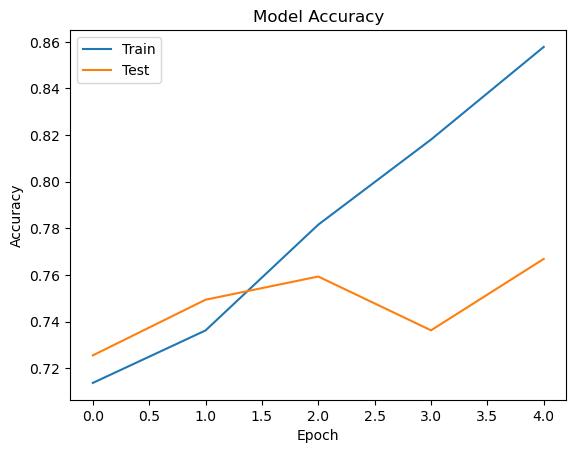

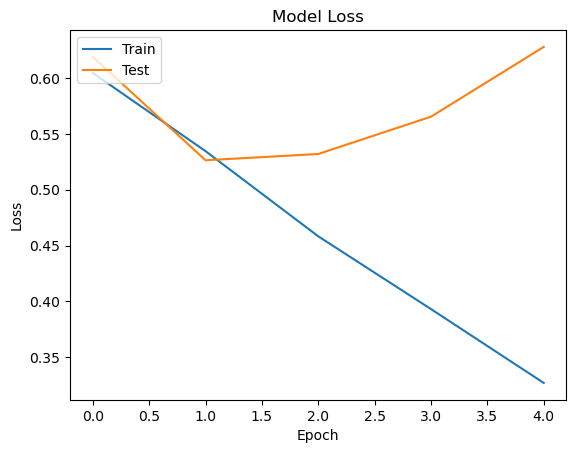

In [ ]:
# Predictions on the Test Set
score = mlp_processed.evaluate(test_features_processed, test_processed['unlisted'], verbose=1)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

# Model Performance Charts
import matplotlib.pyplot as plt

plt.plot(mlp_processed_history.history['binary_accuracy'])
plt.plot(mlp_processed_history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(mlp_processed_history.history['loss'])
plt.plot(mlp_processed_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


113/113 [==============================] - 1s 5ms/step


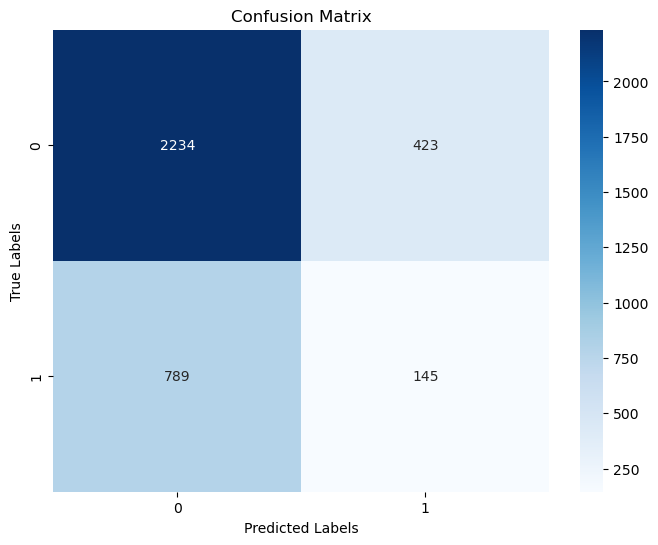

In [ ]:
# Make predictions
predictions = mlp_processed.predict(test_features_processed)

threshold = 0.2
binary_predictions = np.where(predictions >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(test_processed['unlisted'], binary_predictions)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(test_processed['unlisted'], binary_predictions))

              precision    recall  f1-score   support

         0.0       0.74      0.84      0.79      2657
         1.0       0.26      0.16      0.19       934

    accuracy                           0.66      3591
   macro avg       0.50      0.50      0.49      3591
weighted avg       0.61      0.66      0.63      3591



### Logistic Regression:

In [ ]:
# Convert train_features_processed to a numpy array
train_features_processed = np.asarray(train_features_processed)

# Create an instance of the LogisticRegression model
model_log_processed = LogisticRegression()

# Fit the model to the training data
model_log_processed.fit(train_features_processed, train_processed['unlisted'])

# Convert test_features_processed to a numpy array
test_features_processed = np.asarray(test_features_processed)

# Make predictions
predictions_log_processed = model_log_processed.predict(test_features_processed)

In [ ]:
# Calculate accuracy
accuracy = model_log_processed.score(train_features_processed, train_processed['unlisted'])
print('Accuracy:', accuracy)

Accuracy: 0.796515097266977


In [ ]:
# Calculate accuracy
accuracy = model_log_processed.score(test_features_processed, test_processed['unlisted'])
print('Accuracy:', accuracy)

Accuracy: 0.7332219437482596


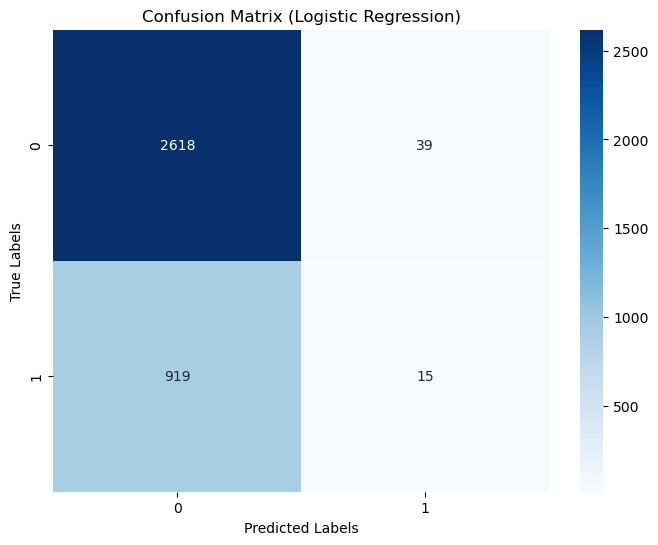

In [ ]:
# Set a threshold for converting predictions to binary values
threshold = 0.2
binary_predictions_log_processed = np.where(predictions_log_processed >= threshold, 1, 0)

# Create a confusion matrix
cm = confusion_matrix(test_processed['unlisted'], binary_predictions_log_processed)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
print(classification_report(test_processed['unlisted'], binary_predictions_log_processed))

              precision    recall  f1-score   support

         0.0       0.74      0.99      0.85      2657
         1.0       0.28      0.02      0.03       934

    accuracy                           0.73      3591
   macro avg       0.51      0.50      0.44      3591
weighted avg       0.62      0.73      0.63      3591

